In [1]:
!pip install -U bitsandbytes
!pip install paddleocr
!pip install paddlepaddle-gpu
!pip install pdf2image
!apt-get install -y poppler-utils
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 71.8 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=4b4650c3b3243717635b11f5f0028ac7f7c856a19a0a1ad8d4d6d7582ff60a0f
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Attempting uninstall: albucore
    Fou

In [2]:
!pip install --upgrade transformers huggingface_hub accelerate

In [3]:
import requests
import cv2
import numpy as np
import torch
from PIL import Image
from paddleocr import PaddleOCR, draw_ocr
from ast import literal_eval
import json
from transformers import MllamaForConditionalGeneration, AutoProcessor, BitsAndBytesConfig

In [ ]:
import os
from pdf2image import convert_from_path

def convert_pdf_to_images(pdf_path, output_folder, dpi=200):
    """
    Converts all pages of a given PDF file into image files and saves them.

    Args:
        pdf_path (str): The local (or absolute) path to the PDF file.
        output_folder (str): The folder where the images will be saved.
        dpi (int, optional): The resolution (dots per inch) for PDF conversion.
                             Defaults to 200.

    Returns:
        list: A list of output image file paths.
    """
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder, exist_ok=True)

    # Convert PDF to a list of PIL Image objects
    pages = convert_from_path(pdf_path, dpi=dpi)

    image_paths = []
    for i, page in enumerate(pages, start=1):
        image_filename = f"pharmacy_page_{i}.jpg"
        image_path = os.path.join(output_folder, image_filename)

        # Save each page as a JPG image
        page.save(image_path, "JPEG")

        image_paths.append(image_path)

    return image_paths


In [ ]:
pdf_file_path = "/content/drive/MyDrive/pharmacy_invoice.pdf"
output_dir = "/content/drive/MyDrive/"

image_files = convert_pdf_to_images(pdf_file_path, output_dir, dpi=200)

print("Images saved to:")
for img_file in image_files:
    print(img_file)

Images saved to:
/content/drive/MyDrive/pharmacy_page_1.jpg


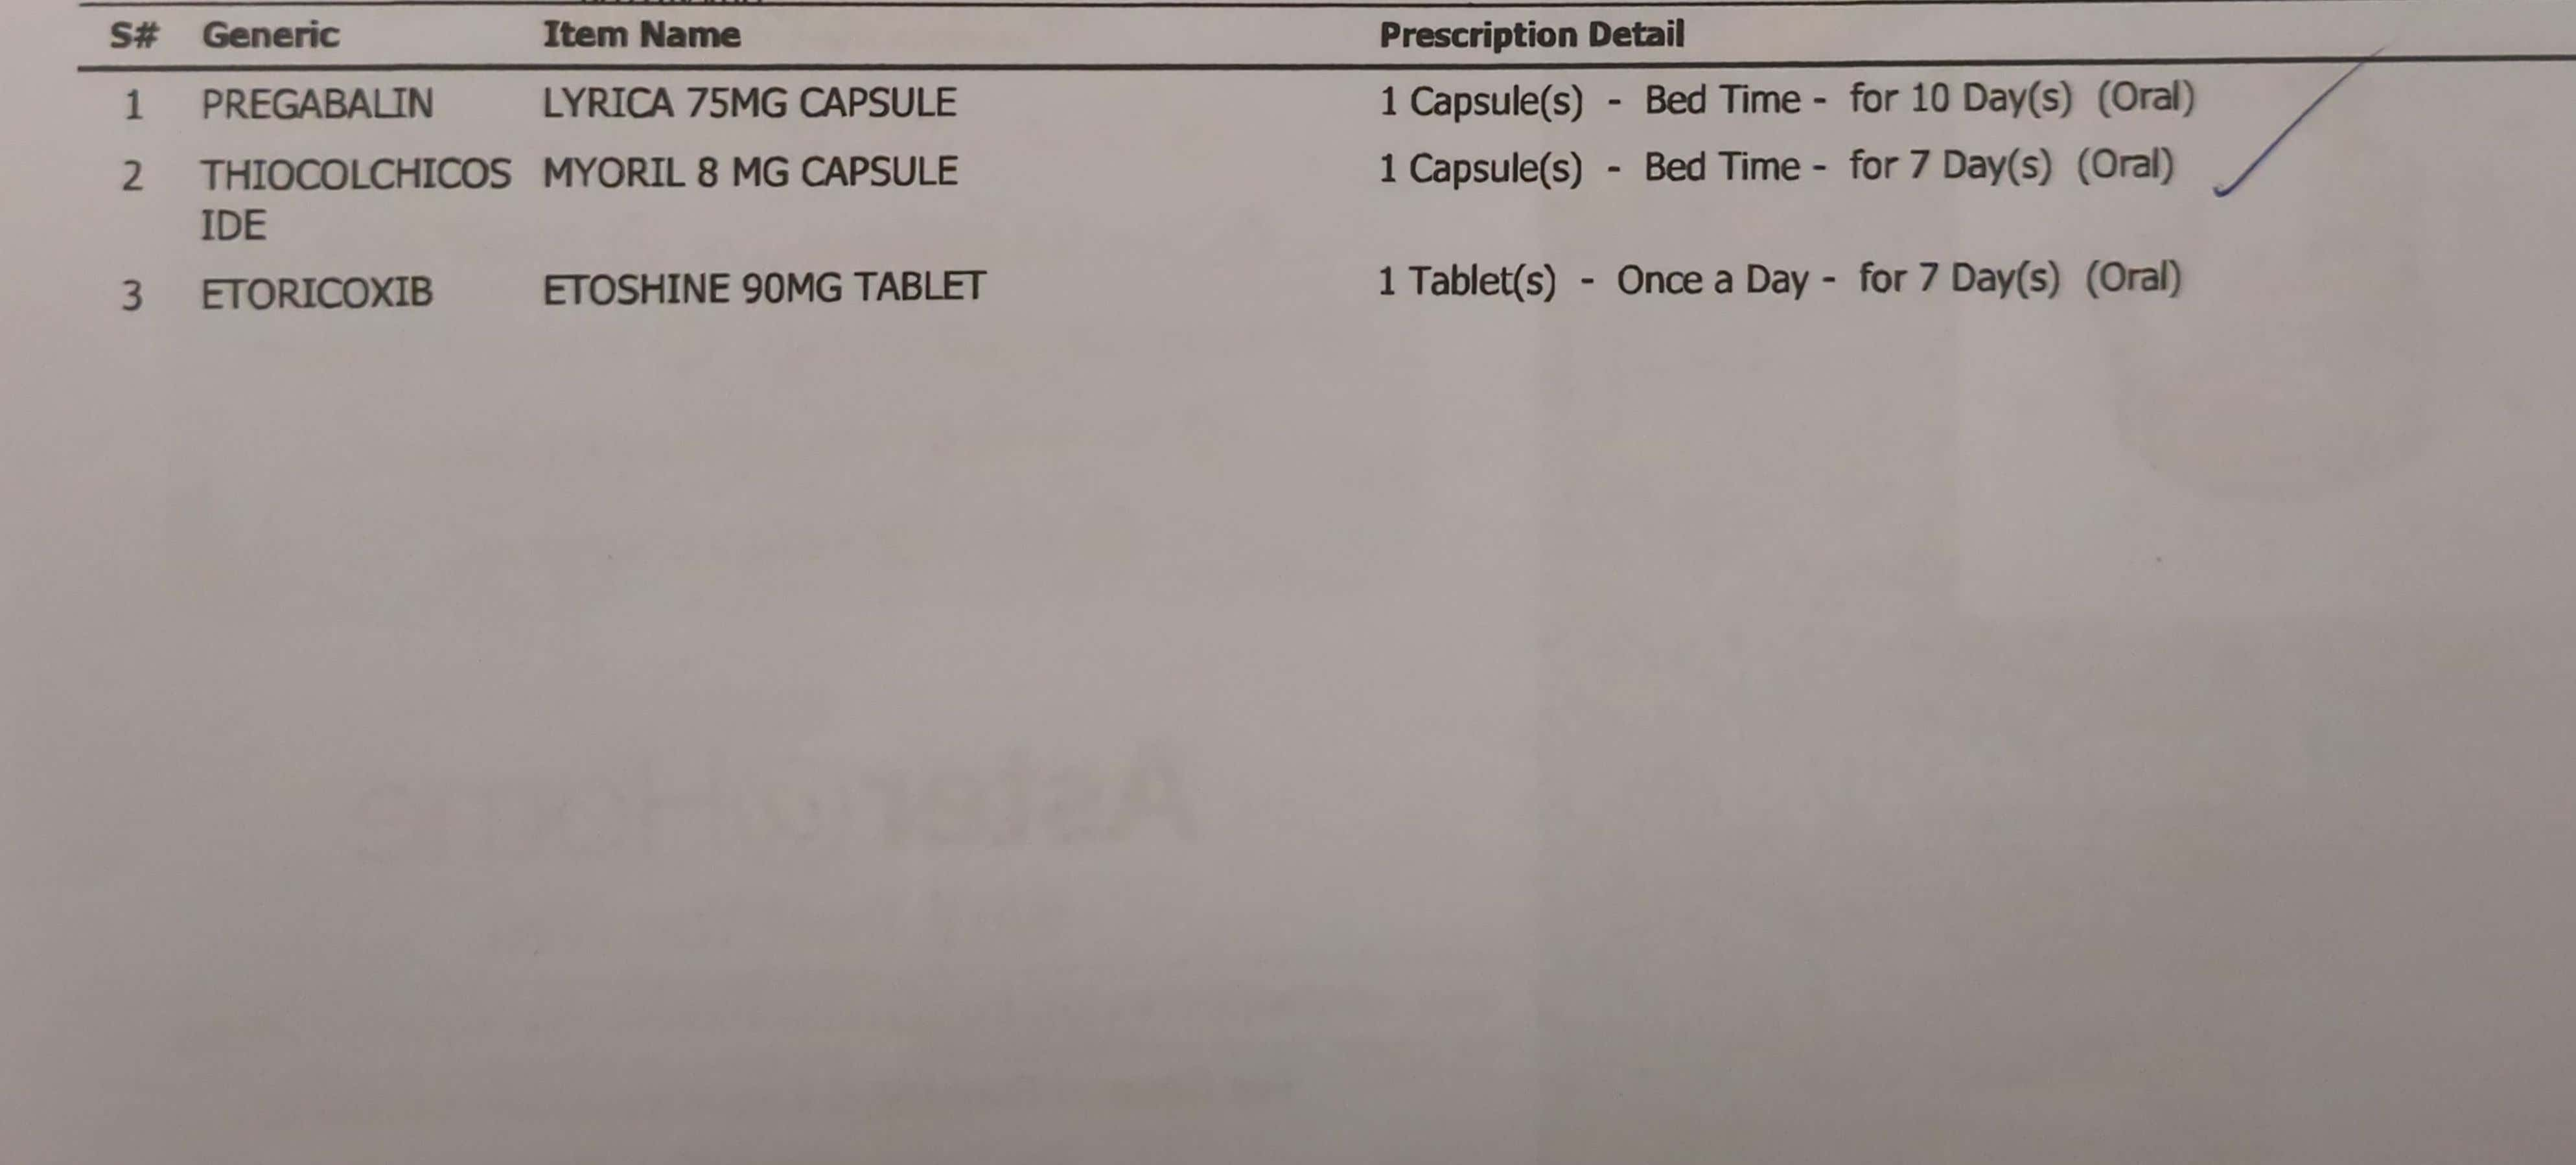

In [4]:
local_image_id='/content/drive/MyDrive/pharmacy_simple.jpg'
receipt_image = Image.open(local_image_id)
receipt_image_array = np.array(receipt_image.convert('RGB'))
display(receipt_image)

In [5]:
%%time
from paddleocr import PaddleOCR, draw_ocr
from ast import literal_eval
import json

paddleocr = PaddleOCR(lang="en",ocr_version="PP-OCRv4",show_log = False,use_gpu=True)

def paddle_scan(paddleocr,img_path_or_nparray):
    result = paddleocr.ocr(img_path_or_nparray,cls=True)
    result = result[0]
    boxes = [line[0] for line in result]       #boundign box
    txts = [line[1][0] for line in result]     #raw text
    scores = [line[1][1] for line in result]   # scores
    return  txts, result

# perform ocr scan
receipt_texts, receipt_boxes = paddle_scan(paddleocr,receipt_image_array)
print(50*"--","\ntext only:\n",receipt_texts)
print(50*"--","\nocr boxes:\n",receipt_boxes)

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:17<00:00, 226.29it/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:18<00:00, 533.29it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:09<00:00, 227.67it/s]

[2024/12/26 14:00:14] ppocr WARNING: The first GPU is used for inference by default, GPU ID: 0


[2024/12/26 14:00:15] ppocr WARNING: The first GPU is used for inference by default, GPU ID: 0
[2024/12/26 14:00:16] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
---------------------------------------------------------------------------------------------------- 
text only:
 ['S#', 'Generic', 'Item Name', 'Prescription Detail', 'PREGABALIN', 'LYRICA 75MG CAPSULE', '1 Capsules)-Bed Time-for 10 Days Oral)', '1', '1 Capsules)-Bed Time-for 7 Days) Oral)', '2', 'THIOCOLCHICOS MYORIL 8 MG CAPSULE', 'IDE', '1 Tablets)- Once a Day-for 7 Day(s) Oral)', 'ETORICOXIB', 'ETOSHINE 9OMG TABLET', '3']
---------------------------------------------------------------------------------------------------- 
ocr boxes:
 [[[[166.0, 20.0], [261.0, 20.0], [261.0, 80.0], [166.0, 80.0]], ('S#', 0.9939364194869995)], [[[302.0, 20.0], [534.0, 20.0], [534.0, 88.0], [302.0, 88.0]], ('Generic', 0.9967225193977356)], [[[830.0, 11.0], [1152.0, 21.0], [1150.

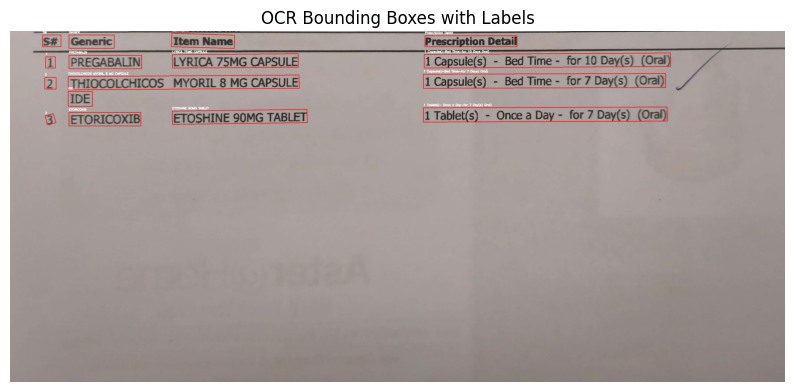

In [6]:
import cv2
import matplotlib.pyplot as plt

# Load your image
image_path = '/content/drive/MyDrive/pharmacy_simple.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

# Define your OCR boxes
# This should be a list of lists where each sub-list represents [top-left, top-right, bottom-right, bottom-left]


# Draw each box on the image
for box, (text, confidence) in receipt_boxes:
    pts = np.array(box, np.int32)
    pts = pts.reshape((-1, 1, 2))
    image = cv2.polylines(image, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

# Optionally, add text labels to the boxes
    cv2.putText(image, text, (int(box[0][0]), int(box[0][1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title('OCR Bounding Boxes with Labels')
plt.axis('off')

# Save the plot to a file
output_path = '/content/drive/MyDrive/pharmacy_simple_annotated.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')

plt.show()

In [9]:
# Load and initialize Llama-3.1-8B model in 4-bit format
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM


model_id= "meta-llama/Llama-3.1-8B-Instruct"

# Configure 4-bit + CPU offload
quant_config = BitsAndBytesConfig(
    load_in_4bit=True
)

tokenizer = AutoTokenizer.from_pretrained(model_id, use_auth_token=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    use_auth_token=True,
    device_map="auto",
    quantization_config=quant_config
)

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [10]:
prompt = prompt = f"""### Instruction:
You are a POS receipt data expert. Parse, detect, and recognize the following receipt OCR image result, then convert it into a structured receipt data object.
Do not invent any values that are not present in the input.
Your output must be a well-formed JSON object.

Extract all the details from the given invoice and provide the information in JSON format
using the template below:

```json
{{
  "prescriptionItems": [
    {{
      "sNo": "",
      "genericName": "",
      "itemName": "",
      "prescriptionDetail": {{
        "quantity": "",
        "frequency": "",
        "duration": "",
        "route": ""
      }}
    }}
  ]
}}


### Input:
{receipt_boxes}

### Output:
"""

In [11]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

with torch.inference_mode():
    # Tokenize and move to device
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)

    # Record how many tokens are in the prompt
    start_index = inputs["input_ids"].shape[-1]

    # Generate
    outputs = model.generate(**inputs, max_new_tokens=1500)

    new_tokens = outputs[0][start_index:]


    result_text = tokenizer.decode(new_tokens, skip_special_tokens=True)

    print(result_text)

# Clear GPU cache
torch.cuda.empty_cache()

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


```json
{
  "prescriptionItems": [
    {
      "sNo": "1",
      "genericName": "PREGABALIN",
      "itemName": "LYRICA 75MG CAPSULE",
      "prescriptionDetail": {
        "quantity": "1 Capsules",
        "frequency": "Bed Time",
        "duration": "10 Days",
        "route": "Oral"
      }
    },
    {
      "sNo": "2",
      "genericName": "THIOCOLCHICOS MYORIL 8 MG CAPSULE",
      "itemName": "IDE",
      "prescriptionDetail": {
        "quantity": "1 Tablets",
        "frequency": "Once a Day",
        "duration": "7 Day(s)",
        "route": "Oral"
      }
    },
    {
      "sNo": "3",
      "genericName": "ETORICOXIB",
      "itemName": "ETOSHINE 9OMG TABLET",
      "prescriptionDetail": {
        "quantity": "3",
        "frequency": "",
        "duration": "",
        "route": ""
      }
    }
  ]
}
```

### Explanation:
This is a receipt OCR image result, which contains the details of the items purchased. The receipt is divided into sections, each representing a different 

In [12]:
import torch
import requests
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor

# 1. Model configuration
model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"  # Example model name
model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_id)
model.tie_weights()

config.json:   0%|          | 0.00/5.07k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

In [13]:
image = Image.open('/content/drive/MyDrive/pharmacy_simple.jpg')

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {
                "type": "text",
                "text": """You are a POS receipt data expert. Parse, detect, and recognize the following receipt OCR image result, then convert it into a structured receipt data object. Do not invent any values that are not present in the input. Your output must be a well-formed JSON object. Extract all the details from the given invoice like  particulars, sno, prescription_detail etc."""
            }
        ]
    }
]



In [14]:
# 4. Prepare input for model
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt"
).to(model.device)

# 5. Run model inference
output = model.generate(**inputs, max_new_tokens=1000)  # Adjust max_new_tokens as desired
decoded_output = processor.decode(output[0], skip_special_tokens=True)

print("=== Model Output ===")
print(decoded_output)


=== Model Output ===
user

You are a POS receipt data expert. Parse, detect, and recognize the following receipt OCR image result, then convert it into a structured receipt data object. Do not invent any values that are not present in the input. Your output must be a well-formed JSON object. Extract all the details from the given invoice like  particulars, sno, prescription_detail etc.assistant

Here is the receipt data in a structured JSON format:

```json
{
  "S#": 1,
  "Generic": "PREGABALIN",
  "Item Name": "LYRICA 75MG CAPSULE",
  "Prescription Detail": "1 Capsule(s) - Bed Time - for 10 Day(s) (Oral)",
  "S#": 2,
  "Generic": "THIOCOLCHICOS IDE",
  "Item Name": "MYORIL 8 MG CAPSULE",
  "Prescription Detail": "1 Capsule(s) - Bed Time - for 7 Day(s) (Oral)",
  "S#": 3,
  "Generic": "ETORICOXIB",
  "Item Name": "ETOSHINE 90MG TABLET",
  "Prescription Detail": "1 Tablet(s) - Once a Day - for 7 Day(s) (Oral)"
}
```
